In [ ]:
import bratsdataset
from torch.utils.data import DataLoader

#constructing datasets
train_path = '/Users/daniel/Documents/CSAI/Advanced Deep Learning/CODE/data/train/'
train_set = bratsdataset.BratsDataset(train_path)

val_path = '/Users/daniel/Documents/CSAI/Advanced Deep Learning/CODE/data/validation/'
val_set = bratsdataset.BratsDataset(val_path)

test_path = '/Users/daniel/Documents/CSAI/Advanced Deep Learning/CODE/data/test/'
test_set = bratsdataset.BratsDataset(test_path)

#data loaders
batch_size = 2 #8

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

#test
images, masks = next(iter(train_loader))
print("Image batch shape:", images.shape)
print("Mask batch shape:", masks.shape)

Image batch shape: torch.Size([2, 1, 240, 240, 160])
Mask batch shape: torch.Size([2, 1, 240, 240, 160])


In [7]:
import models
import loops
import utils
import torch
import torch.nn as nn
import torch.optim as optim

#setting up training
model = models.Unet3Dbrats()
device = torch.device("cpu")
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 1
early_stopping = utils.EarlyStopping(patience=5, delta=0.001)

#constructing trainer
trainer = loops.Trainer(
    model=model, 
    device=device, 
    criterion=criterion, 
    optimizer=optimizer, 
    num_epochs=num_epochs, 
    early_stopping=early_stopping, 
    train_loader=train_loader, 
    val_loader=val_loader,
    test_loader=test_loader, 
    save_path="Images/loss_test.png"
    )

In [ ]:
trainer.train()

In [5]:
trainer.test()

Test runtime 94.21402215957642
Mean dice coefficient on test set: 0.0222
Mean loss on test set: 0.6748


In [9]:
torch.save(model, "brats_model_test.pt")

### RISE

In [12]:
import torch
import torch.nn as nn
import time
import matplotlib.pyplot as plt
import numpy as np
import utils
import bratsdataset
from torch.utils.data import DataLoader

model = torch.load("brats_model_test.pt", weights_only=False, map_location=torch.device('cpu'))

rise_path = '/Users/daniel/Documents/CSAI/Advanced Deep Learning/CODE/data/rise/'
rise_set = bratsdataset.BratsDataset(rise_path)
batch_size = 2
rise_loader = DataLoader(rise_set, batch_size=batch_size, shuffle=True)

images, masks = next(iter(rise_loader))
print("Image batch shape:", images.shape)
print("Mask batch shape:", masks.shape)

Image batch shape: torch.Size([2, 1, 240, 240, 160])
Mask batch shape: torch.Size([2, 1, 240, 240, 160])


In [13]:
#RISE

rise_start = time.time()

device = 'cpu'
criterion = nn.BCELoss()
test_dice = 0.0
test_loss = 0.0
model.eval()

with torch.no_grad():

    for images, masks in rise_loader:

        images, masks = images.to(device), masks.to(device)

        outputs = model(images)
        dice = utils.dice_coeff(outputs, masks)
        loss = criterion(outputs, masks)
        
        #balance the loss per batch size
        test_dice += dice * images.size(0)
        test_loss += loss.item() * images.size(0)
    
test_dice /= len(rise_loader.dataset)    
test_loss /= len(rise_loader.dataset)

print(f"Mean dice coefficient on test set: {test_dice:.4f}")
print(f"Mean loss on test set: {test_loss:.4f}")
print()

rise_end = time.time()
print(f"Test runtime {rise_end - rise_start}")
print()

Mean dice coefficient on test set: 0.0239
Mean loss on test set: 0.7483

Test runtime 37.47508692741394



In [ ]:
'''#plot RISE heatmap
slicez = heatmap[103, :, :]
slicey = heatmap[:, 100, :]
slicex = heatmap[:, :, 89]

slices = [slicez, slicey, slicex]

fig, axes = plt.subplots(1, 3, figsize=(14, 21))
for i, s in enumerate(slices):
    axes[i].imshow(np.flipud(s.T), cmap='gray')
    axes[i].axis("off")

plt.savefig("/images/rise_heatmap1.png")
print('heatmap1')'''

torch.float32
torch.Size([2, 1, 240, 240, 160])
torch.Size([240, 240, 160]) torch.float32
torch.Size([240, 240, 160]) torch.float32
Outputs:  torch.Size([240, 240, 160]) torch.float32



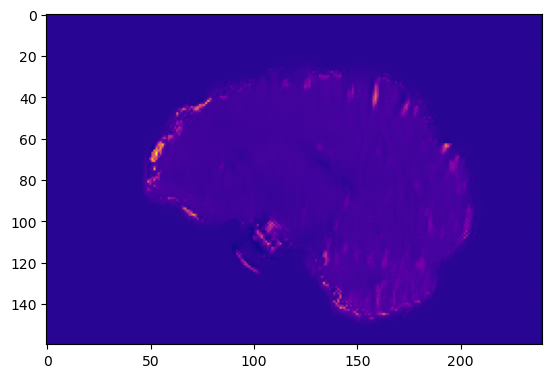

In [15]:
images, masks = next(iter(rise_loader))

print(outputs.dtype)

print(images.shape)

rise_image = images[0][0]
rise_mask = masks[0][0]
rise_output = outputs[0][0]

print(rise_image.shape, rise_image.dtype)
print(rise_mask.shape, rise_mask.dtype)

print('Outputs: ', rise_output.shape, rise_output.dtype)
print()

output_slice = rise_output[103, :, :]

plt.figure()
plt.imshow(np.flipud(output_slice.T), cmap="plasma")
